In [26]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = ['Helvetica']
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 14

### Read the File

In [13]:
df = pd.read_parquet('/N/project/INCAS/bluesky/toxicity_merged/toxicity_merged.parquet')

### Summary

In [ ]:
def getlower(g):
    return np.percentile(g, 2.5)

def getupper(g):
    return np.percentile(g, 97.5)

# pivot table
summary = df[df['without_none']].pivot_table(index='Date', values='max_score', aggfunc = ['mean', getlower, getupper])

# only the reliable data
summary = summary[summary.index >= datetime.date(2023,8,19)]

# rename the columns
summary.columns = ['Average', '2.5%', '97.5%']

In [18]:
# get the high categories
df['high_categories'] = df['category_scores'].apply(lambda x: {k:v for k,v in x.items() if v>=.5})

# binary toxic
df['is_toxic'] = df['high_categories'].apply(lambda x: 1 if len(x)>=1 else 0)

### Define Important Dates

In [20]:
launch_date = datetime.date(2023,2,28)

public_date = datetime.date(2024,2,6)

brazil_twitter_ban = datetime.date(2024,8,30)

ban_lift = datetime.date(2024,10,8)

block_policy = datetime.date(2024,10,16)

elections = datetime.date(2024,11,2)

reliable_date = datetime.date(2023,8,19)

focus_date = datetime.date(2024,8,21)

In [21]:
important_dates = {'Public Access':public_date, 'Brazil X Ban':brazil_twitter_ban, 'Ban Lift':ban_lift, 'X Block Policy Change':block_policy, 'US Elections':elections}

colors = {
        'All':'black',
        'Brazil X Ban':'#006ba4',
        'US Elections':'#ff800e',
        'Public Access':'#8B0000',
        'X Block Policy Change':'#FFC0CB',
        'en':'#ff800e',
        'pt':'#006ba4',
        'ja':'#8B0000',
        }

### Visualize

In [22]:
daily_toxic_post = df.pivot_table(index='Date', values='is_toxic', aggfunc=['sum','count'])

daily_toxic_post.columns = ['Toxic Count', 'Total Count']

daily_toxic_post['Toxic Ratio'] = daily_toxic_post['Toxic Count'] / daily_toxic_post['Total Count']

daily_toxic_post = daily_toxic_post[daily_toxic_post.index>=reliable_date]

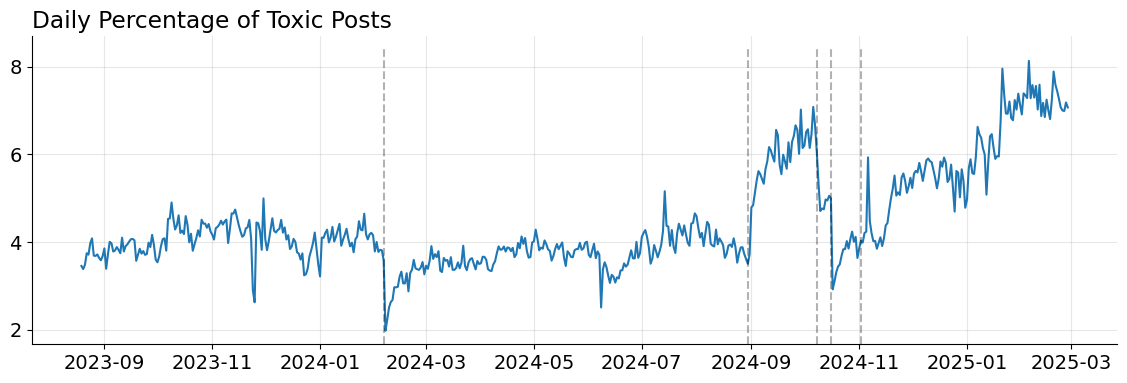

In [23]:
fig, axs = plt.subplots(figsize=(14,4))

axs.plot(daily_toxic_post['Toxic Ratio']*100)

axs.set_title('Daily Percentage of Toxic Posts', loc='left')
axs.grid(alpha=.3)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
i = 0
ymin, ymax = axs.get_ylim()
for event, date in important_dates.items():
    axs.vlines(date, ymin, ymax, color='black', linestyles='--', alpha=.3)
    # text = axs.text(date+datetime.timedelta([-35, -70, -35, 10, 10][i]),
    #                     ymax*[.92, .9, .9, .5, .8][i],
    #                     event, 
    #                     verticalalignment='bottom',
    #                     horizontalalignment='left')
    i += 1
axs.set_ylim(ymin, ymax*1.03)

fig.savefig('/N/u/oseckin/BigRed200/rise_of_bluesky/figures/daily_percentage_of_toxic_posts.pdf')
fig.show()

In [24]:
df['high_categories'] = df['high_categories'].apply(lambda x: [*x.keys()])

In [27]:
category_counts = df.groupby('Date')['high_categories'].apply(lambda x: [item for sublist in x for item in sublist])
category_counts = category_counts.apply(lambda x: Counter(x))
category_counts = category_counts.apply(lambda x: sorted([(k,v) for k,v in x.items()], key=lambda x:x[1], reverse=True))
category_counts = category_counts.apply(lambda x: {k:v for k,v in x})

category_counts = category_counts[category_counts.index>=reliable_date]

In [ ]:
category_list = [*category_counts.iloc[-1].keys()]

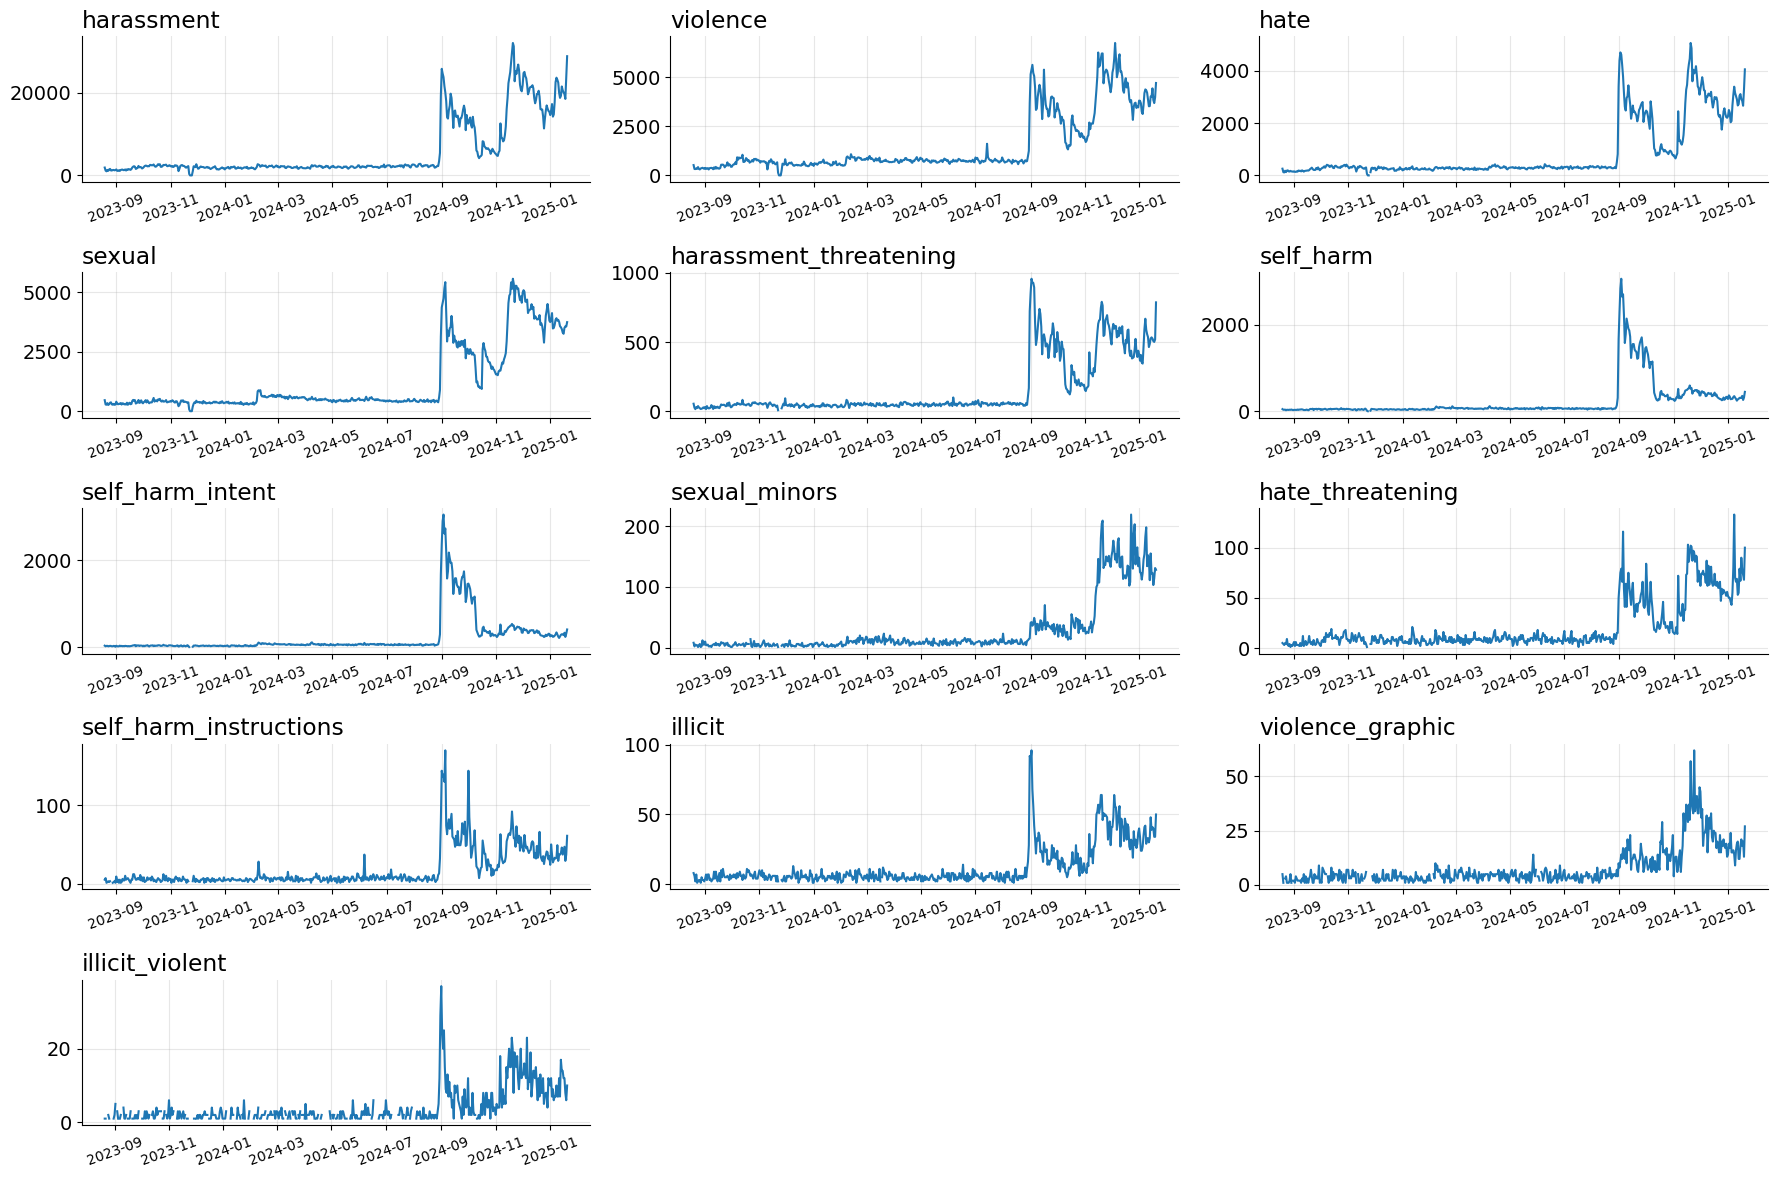

In [ ]:
fig, axs = plt.subplots(5,3, figsize=(18,12))

i = 0
for row in axs:
    for ax in row:
        if i > 12:
            break
        c = category_list[i]
        ax.plot(category_counts.apply(lambda x: x.get(c)))
        ax.set_title(c, loc='left')
        ax.grid(alpha=.3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        i += 1
        ax.tick_params('x', labelsize=10, rotation=20)

axs[4][1].set_visible(False)
axs[4][2].set_visible(False)

fig.tight_layout()
fig.savefig('/N/u/oseckin/BigRed200/rise_of_bluesky/figures/toxicity_by_category.pdf')
fig.show()